### Loading Dataset

In [ ]:
# importing data from dropbox
!wget https://www.dropbox.com/scl/fi/uolxk8iujs00u3a83d5od/myomasData.zip?rlkey=twu4sq0hbff55yoemh6lpzubo&dl=0

In [ ]:
!unzip -q "/content/myomasData.zip?rlkey=twu4sq0hbff55yoemh6lpzubo"

### Importing Libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

### Setting Training and Evaluation Data Paths

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Set your dataset paths
train_dir = '/content/myomasData/train'
test_dir = '/content/myomasData/test'
val_dir = '/content/myomasData/val'

In [ ]:
from PIL import Image
import os

In [ ]:
nuf_path = 'myomasData/train/nuf'
uf_path = 'myomasData/train/uf'

In [ ]:
image_sizes = {'nuf': [], 'uf': []}
for image_filename in os.listdir(nuf_path):
    image_path = os.path.join(nuf_path, image_filename)
    image = Image.open(image_path)
    width, height = image.size
    image_sizes['nuf'].append((width, height))

for image_filename in os.listdir(uf_path):
    image_path = os.path.join(uf_path, image_filename)
    image = Image.open(image_path)
    width, height = image.size
    image_sizes['uf'].append((width, height))

In [ ]:
for class_label, sizes in image_sizes.items():
    if sizes:
        avg_width = sum(w for w, _ in sizes) / len(sizes)
        avg_height = sum(h for _, h in sizes) / len(sizes)
        print(f"Class: {class_label}, Average Width: {avg_width:.2f}, Average Height: {avg_height:.2f}")
    else:
        print(f"No images found for class: {class_label}")


Class: nuf, Average Width: 720.00, Average Height: 542.71
Class: uf, Average Width: 720.00, Average Height: 538.54


### Data Generation and Preprocessing

In [ ]:
# Define data generators
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess train data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Adjust the target size based on your model requirements
    batch_size=32,
    class_mode='binary',     # Change to 'categorical' if you have multiple classes
    shuffle=True
)

#Load and process val data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)
# Load and preprocess test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 572 images belonging to 2 classes.
Found 157 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


## Data Exploration & Analysis

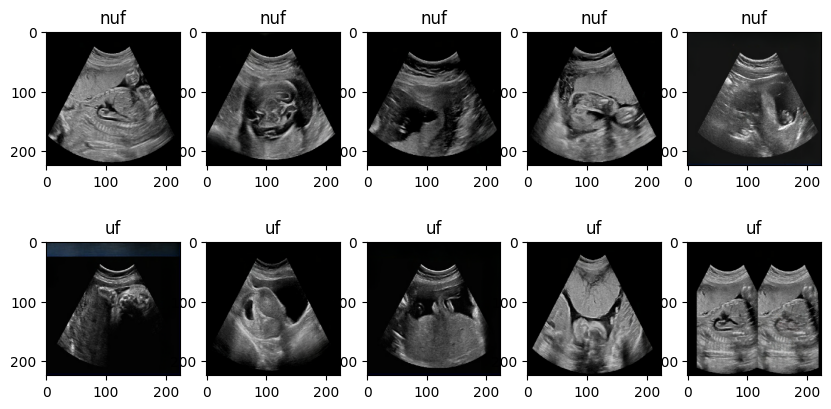

In [ ]:
# Visualize some sample images
sample_normal_images, _ = next(train_generator)
sample_sick_images, _ = next(train_generator)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_normal_images[i])
    plt.title('nuf')
    plt.axis('on')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(sample_sick_images[i])
    plt.title('uf')
    plt.axis('on')

plt.show()

### Data Class Distribution

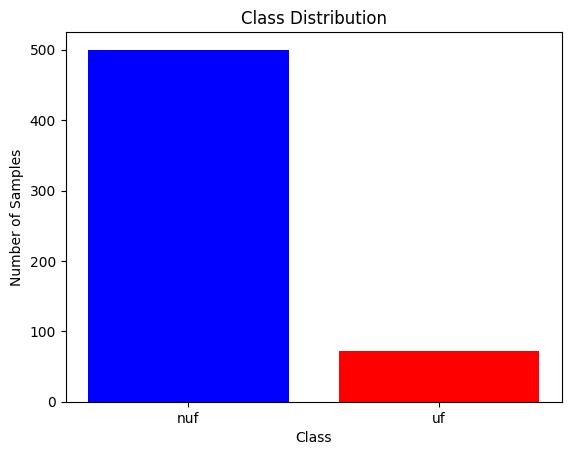

In [ ]:
# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Get the number of samples in each class
num_normal_samples = len(os.listdir(os.path.join(train_dir, 'nuf')))
num_sick_samples = len(os.listdir(os.path.join(train_dir, 'uf')))

# Plot a bar chart of class distribution
plt.bar(class_labels, [num_normal_samples, num_sick_samples], color = ['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

### Image Pixel Intensity

NUF Image Dimensions: (720, 540)
UF Image Dimensions: (720, 540)


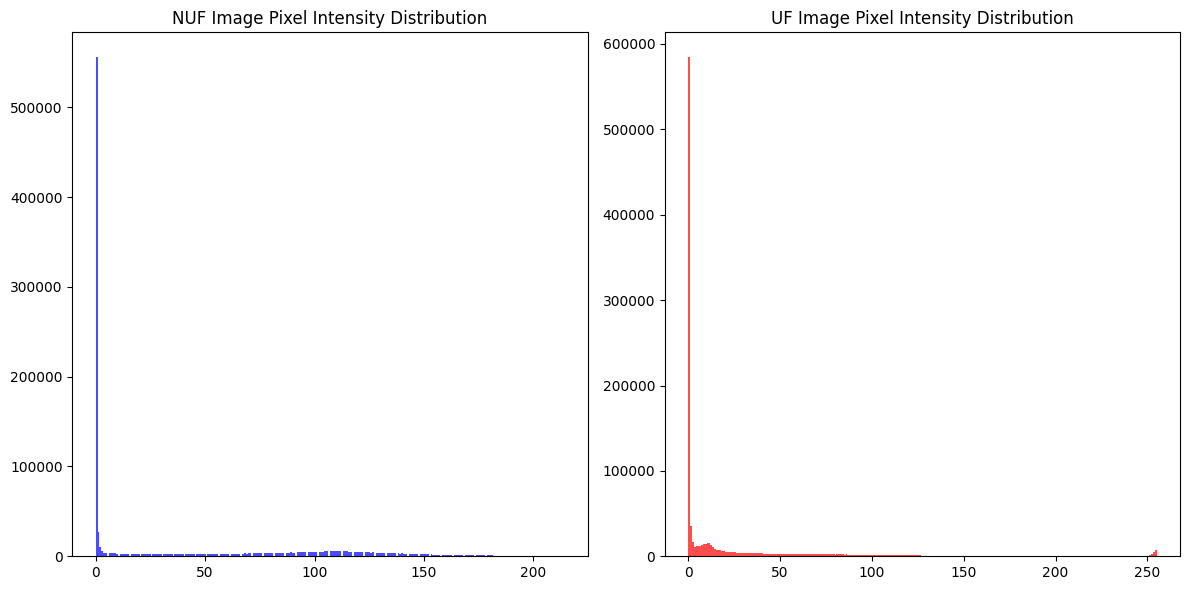

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image  # Assuming you're using PIL to work with images

train_dir = 'myomasData/train'  # Replace with your actual directory path

# Get dimensions of a few sample images
normal_sample_img = Image.open(os.path.join(train_dir, 'nuf', os.listdir(os.path.join(train_dir, 'nuf'))[0]))
sick_sample_img = Image.open(os.path.join(train_dir, 'uf', os.listdir(os.path.join(train_dir, 'uf'))[0]))

print("NUF Image Dimensions:", normal_sample_img.size)
print("UF Image Dimensions:", sick_sample_img.size)

# Plot pixel intensity distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(np.array(normal_sample_img).ravel(), bins=256, color='blue', alpha=0.7)
plt.title('NUF Image Pixel Intensity Distribution')

plt.subplot(1, 2, 2)
plt.hist(np.array(sick_sample_img).ravel(), bins=256, color='red', alpha=0.7)
plt.title('UF Image Pixel Intensity Distribution')

plt.tight_layout()
plt.show()

### Pixel Intensity of Sample Images

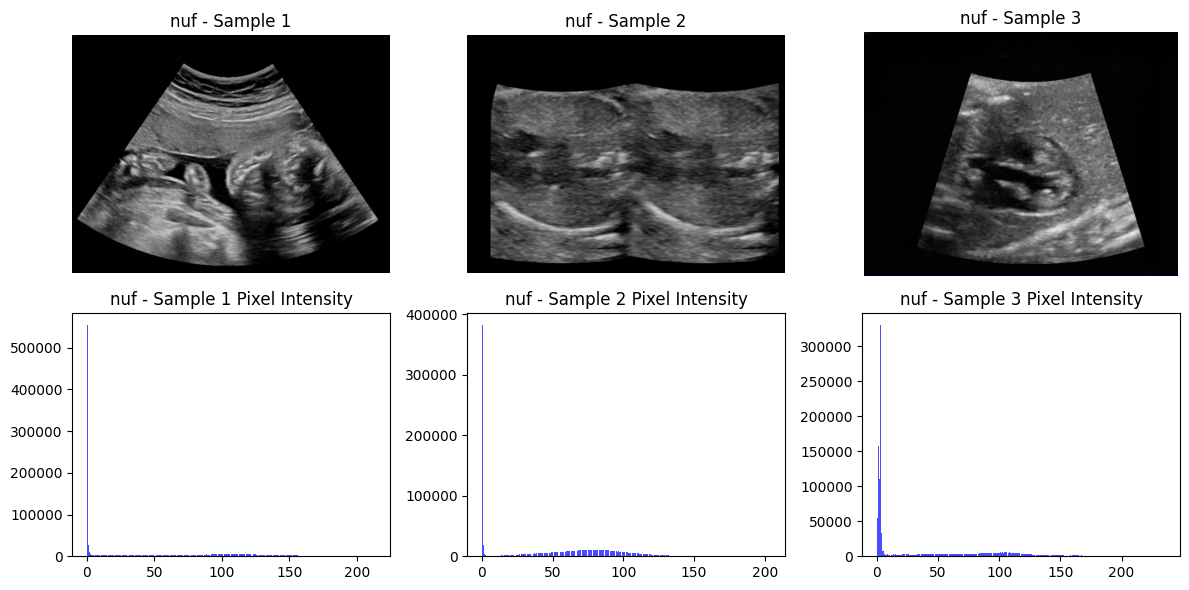

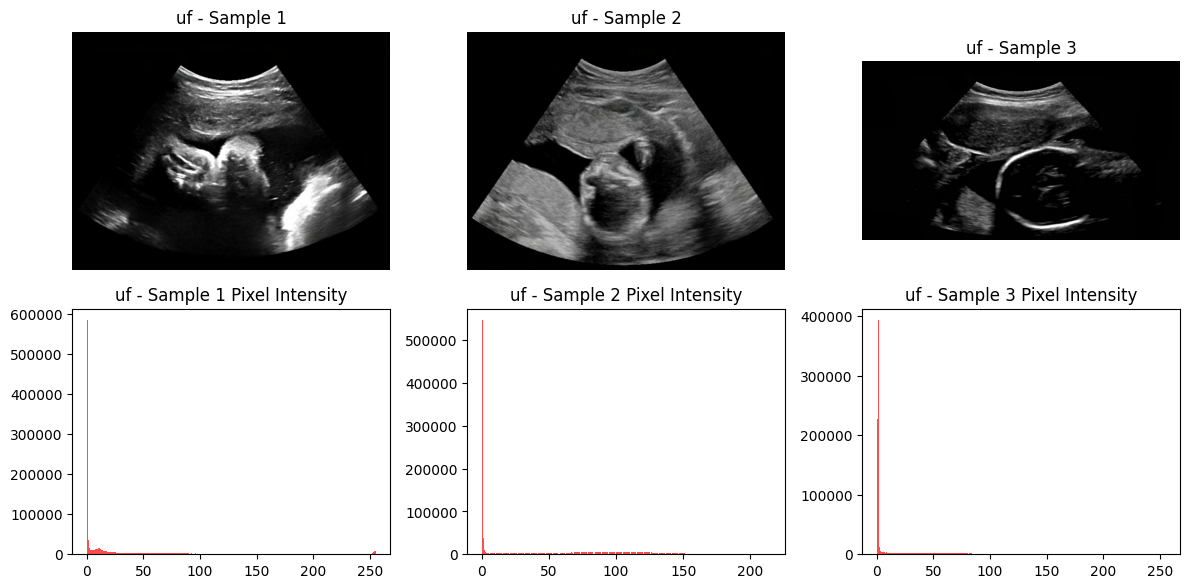

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

train_dir = 'myomasData/train'  # Replace with your actual directory path
nuh_class_dir = os.path.join(train_dir, 'nuf')
uf_class_dir = os.path.join(train_dir, 'uf')

# Get a list of image filenames from each class directory
nuh_images = [os.path.join(nuh_class_dir, img) for img in os.listdir(nuh_class_dir)]
uf_images = [os.path.join(uf_class_dir, img) for img in os.listdir(uf_class_dir)]

# Function to plot pixel intensity distribution for a list of images
def plot_pixel_intensity(images, title):
    plt.figure(figsize=(12, 6))
    for i, img_path in enumerate(images, start=1):
        img = Image.open(img_path)
        plt.subplot(2, len(images), i)
        plt.imshow(img)
        plt.title(f"{title} - Sample {i}")
        plt.axis('off')

        plt.subplot(2, len(images), len(images) + i)
        plt.hist(np.array(img).ravel(), bins=256, color='blue' if title == 'nuf' else 'red', alpha=0.7)
        plt.title(f"{title} - Sample {i} Pixel Intensity")

    plt.tight_layout()
    plt.show()

# Plot pixel intensity distributions for sample images from each class
plot_pixel_intensity(nuh_images[:3], 'nuf')
plot_pixel_intensity(uf_images[:3], 'uf')


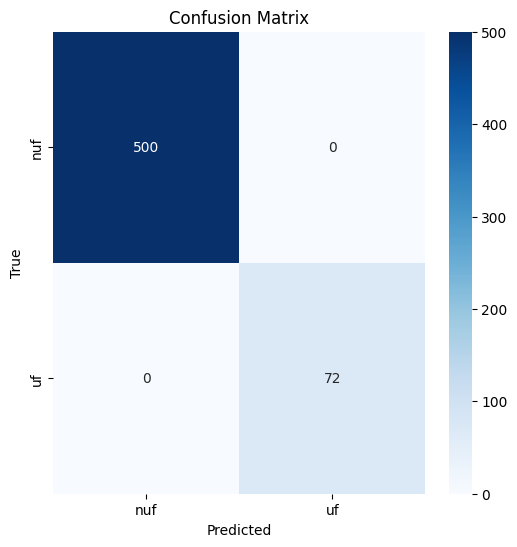

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
# True labels for the images ("NUF" for normal, "UF" for sick)
true_labels = ["nuf"] * len(nuh_images) + ["uf"] * len(uf_images)

# Predicted labels (this is just an example, replace with your predictions)
predicted_labels = ["nuf"] * len(nuh_images) + ["uf"] * len(uf_images)

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=["nuf", "uf"])

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["nuf", "uf"], yticklabels=["nuf", "uf"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Applying Data Resamplying Due to Imbalance

In [ ]:
import os
from sklearn.utils import shuffle
from sklearn.utils import resample

# Paths to the image directories
normal_dir = 'myomasData/train/nuf'  # Replace with your path
sick_dir = 'myomasData/train/uf'      # Replace with your path

# Get all image paths
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
sick_images = [os.path.join(sick_dir, img) for img in os.listdir(sick_dir)]

# Randomly downsample normal images to match the number of sick images
normal_images_downsampled = resample(normal_images,
                                     replace=False,    # sample without replacement
                                     n_samples=len(sick_images),  # to match minority class
                                     random_state=123) # reproducible results

# Combine sick images with downsampled normal images
balanced_images = sick_images + normal_images_downsampled

# Create labels
balanced_labels = [1] * len(sick_images) + [0] * len(normal_images_downsampled)

# Shuffle the dataset together with the labels
balanced_images, balanced_labels = shuffle(balanced_images, balanced_labels, random_state=123)

# Now you can load these images and train your model with a balanced dataset
# You can create a generator or a custom data loader to feed these into your model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Create image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')


Found 572 images belonging to 2 classes.
Found 157 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


### Preprocessing Dataset after Resampling




In [ ]:
from keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class MyDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size=(200, 200), shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        image_paths_temp = [self.image_paths[k] for k in indexes]
        X, y = self.__generate_data(image_paths_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __generate_data(self, image_paths_temp):
        X = np.empty((self.batch_size, *self.target_size, 3))
        y = np.empty((self.batch_size), dtype=int)
        for i, img_path in enumerate(image_paths_temp):
            img = load_img(img_path, target_size=self.target_size)
            img = img_to_array(img)
            img /= 255.0
            X[i,] = img
            y[i] = self.labels[i]
        return X, y

# Create instances of the data generator
train_gen = MyDataGenerator(balanced_images, balanced_labels, batch_size=32)

## Using Baseline Classification Model

### Create and Compile Baseline Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


### Baseline Model Training

In [ ]:
# history = model.fit(
#     train_gen,
#     epochs=15,
#     steps_per_epoch=len(train_gen),
#     validation_data=val_generator,  # corrected to use the generator
#     validation_steps=len(val_generator)  # corrected to use the length of the generator
# )

history = model.fit(
     train_datagen,
    epochs=20,
    validation_data=val_datagen
)

### Training & Validation Curves

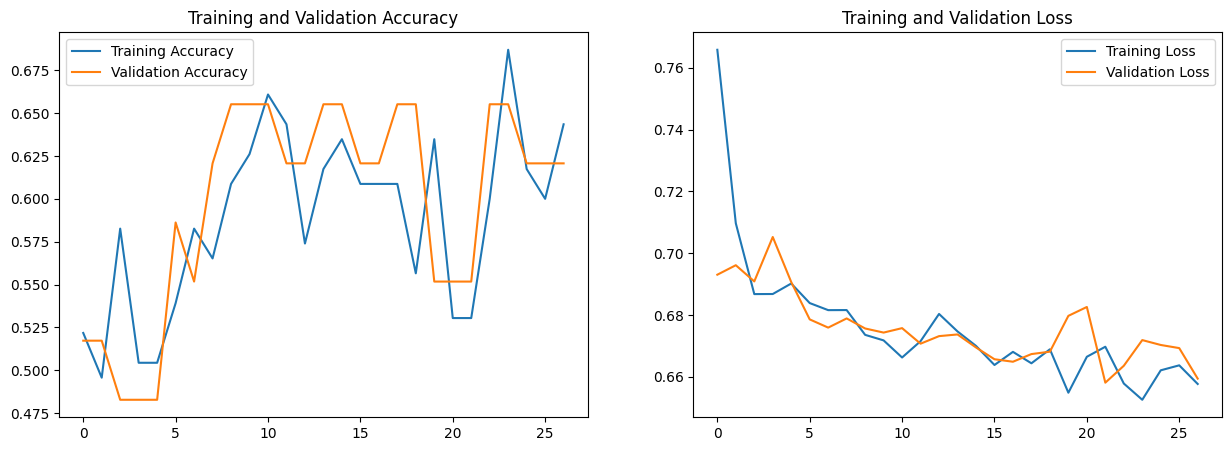

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


### Baseline Model Evaluation

In [ ]:
# Load the best model
model.load_weights('best_model.h5')

# Predict on the validation set (use the same preprocessing as for training)
predictions = model.predict(val_generator)

# Apply a threshold to get binary predictions
threshold = 0.5  # This threshold can be adjusted based on your requirements
binary_predictions = [1 if pred > threshold else 0 for pred in predictions]

from sklearn.metrics import classification_report, confusion_matrix

# Generate a classification report
print(classification_report(y_val, binary_predictions, target_names=['Normal', 'Sick']))

# Confusion matrix
cm = confusion_matrix(y_val, binary_predictions)


1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

      Normal       0.50      0.40      0.44        15
        Sick       0.47      0.57      0.52        14

    accuracy                           0.48        29
   macro avg       0.49      0.49      0.48        29
weighted avg       0.49      0.48      0.48        29



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get the true labels
true_labels = test_generator.classes

# Make sure to only take the number of predictions that match the number of true labels
true_labels = true_labels[:len(binary_predictions)]

# Compute confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Display the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report
print(classification_report(true_labels, binary_predictions))

## Using Pre-trained ResNet50 Classification Model

### Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
SPLIT = 0.3
EPOCHS = 80
BATCH_SIZE = 64

In [ ]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

train_data = datagen.flow_from_directory("myomasData/train",
                                       target_size=(256, 256),
                                       class_mode="binary",
                                       batch_size=BATCH_SIZE)

test_data = datagen.flow_from_directory("myomasData/test",
                                       target_size=(256, 256),
                                       class_mode="binary",
                                       shuffle=False,
                                       batch_size=BATCH_SIZE)

val_data = datagen.flow_from_directory("myomasData/val",
                                       target_size=(256, 256),
                                       class_mode="binary",
                                       shuffle=False,
                                       batch_size=BATCH_SIZE)

Found 572 images belonging to 2 classes.
Found 72 images belonging to 2 classes.
Found 157 images belonging to 2 classes.


### Model Architecture

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 model, excluding the top fully connected layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base_model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for binary classification
x = base_model.output
#x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Use 'sigmoid' for binary classification

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

learning_rate=0.0003
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
# Compile the model
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping callback to stop training when the validation loss has not improved for 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # To log when training is being stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

In [ ]:
# Create data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'myomasData/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')  # Use 'binary' for binary classification

validation_generator = val_datagen.flow_from_directory(
        'myomasData/val',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')  # Use 'binary' for binary classification

Found 572 images belonging to 2 classes.
Found 157 images belonging to 2 classes.


In [ ]:
# Train the model on your data
history =model.fit(
          train_generator,
          steps_per_epoch=train_generator.samples // train_generator.batch_size,
          epochs=EPOCHS,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples // validation_generator.batch_size)

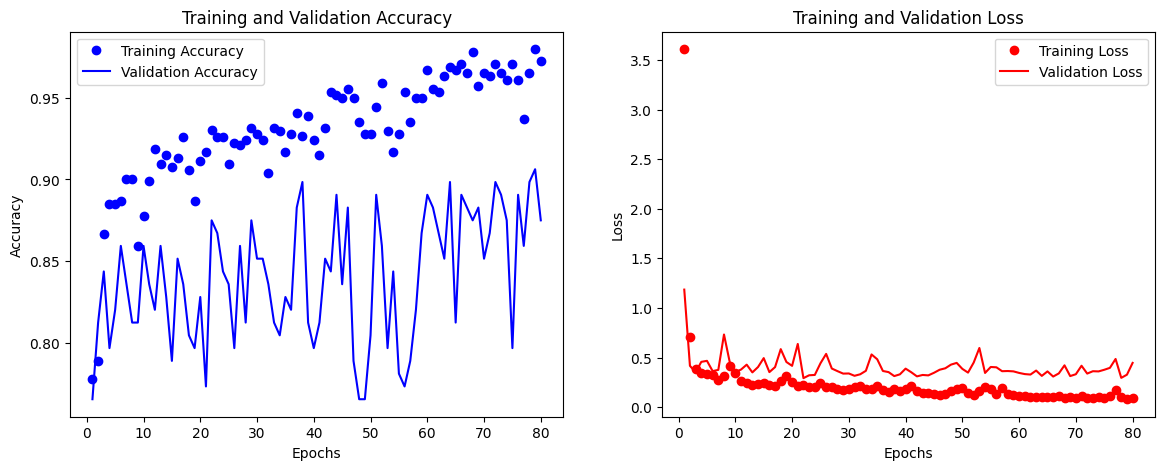

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from the 'fit' method
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Assuming you have a test data generator similar to train_generator
test_generator = val_datagen.flow_from_directory(
    'myomasData/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False)  # Important: keep data in same order as labels

# Predict on the entire test data
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Convert probabilities to binary predictions
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

Found 72 images belonging to 2 classes.
2/2 [==============================] - 1s 277ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get the true labels
true_labels = test_generator.classes

# Make sure to only take the number of predictions that match the number of true labels
true_labels = true_labels[:len(binary_predictions)]

# Compute confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Display the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report
print(classification_report(true_labels, binary_predictions))
